2025-10-15 01:11:32,523 - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


Results directory: C:\Users\Boris\Desktop\code\multilingual-rag\results
Loading: hindi_healthcare_rag_20251015_010536.csv

✓ Loaded 30 experiment results
Columns: 30 columns

Languages in dataset: Hindi (all questions)
Questions processed: 30


C:\Users\Boris\Desktop\code\multilingual-rag\mul-rag\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2025-10-15 01:11:35,342 - INFO - Use pytorch device_name: cpu
2025-10-15 01:11:35,355 - INFO - Using default tokenizer.


✓ Initialized evaluator with model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Evaluating 30 questions...

[1/30] इंसुलिन प्रतिरोध क्या है?...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.375
  ROUGE-L (English): 0.023
  Time speedup: 1.80x

[2/30] हृदय रोग के जोखिम कारक कौन-कौन से हैं जिन्हें बदला...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.504
  ROUGE-L (English): 0.028
  Time speedup: 0.87x

[3/30] शराब का सेवन हृदय रोग के जोखिम को कैसे प्रभावित कर...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.950
  ROUGE-L (English): 0.424
  Time speedup: 0.81x

[4/30] मदर या बहन को हृदय रोग होने पर आपकी जोखिम कब बढ़ ज...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.819
  ROUGE-L (English): 0.326
  Time speedup: 0.71x

[5/30] दैनिक शराब सेवन की सीमा पुरुषों और महिलाओं के लिए ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.715
  ROUGE-L (English): 0.350
  Time speedup: 0.78x

[6/30] किस समूह के एशियाई अमेरिकियों में हृदय रोग की दर अ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.956
  ROUGE-L (English): 0.640
  Time speedup: 0.86x

[7/30] तनाव का हृदय रोग से क्या संबंध है?...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.398
  ROUGE-L (English): 0.014
  Time speedup: 0.83x

[8/30] हृदय रोग के लिए पारिवारिक इतिहास का क्या महत्व है?...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.531
  ROUGE-L (English): 0.056
  Time speedup: 1.17x

[9/30] मदर या बहन के हृदय रोग से पीड़ित होने पर आपकी जोखि...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.957
  ROUGE-L (English): 0.455
  Time speedup: 0.48x

[10/30] मदर या बहन के हृदय रोग से पीड़ित होने पर आपकी जोखि...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.889
  ROUGE-L (English): 0.308
  Time speedup: 0.51x

[11/30] मेपिवाकेन हाइड्रोक्लोराइड का उपयोग किस लिए किया जा...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.554
  ROUGE-L (English): 0.100
  Time speedup: 0.85x

[12/30] मादक दर्दनाशक के रूप में कौन सी दवा उपयोग की जाती ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.538
  ROUGE-L (English): 0.174
  Time speedup: 1.24x

[13/30] मादक दर्दनाशक इंजेक्शन का पीएच स्तर क्या होता है?...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.756
  ROUGE-L (English): 0.276
  Time speedup: 0.64x

[14/30] मेपिवाकेन हाइड्रोक्लोराइड का संरचनात्मक सूत्र क्या...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.789
  ROUGE-L (English): 0.571
  Time speedup: 0.94x

[15/30] दवा की प्लाज्मा प्रोटीन से बंधन की प्रक्रिया कैसे ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.752
  ROUGE-L (English): 0.391
  Time speedup: 0.93x

[16/30] किस प्रकार की एनेस्थीसिया के लिए मेपिवाकेन का उपयो...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.873
  ROUGE-L (English): 0.385
  Time speedup: 0.67x

[17/30] मादक दर्दनाशक इंजेक्शन में मेपरिडीन हाइड्रोक्लोराइ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.729
  ROUGE-L (English): 0.196
  Time speedup: 0.94x

[18/30] मादक दर्दनाशक इंजेक्शन का स्वाद कैसा होता है?...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.644
  ROUGE-L (English): 0.414
  Time speedup: 1.06x

[19/30] मादक दर्दनाशक इंजेक्शन का स्वाद कैसा होता है?...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.581
  ROUGE-L (English): 0.318
  Time speedup: 1.01x

[20/30] ज़ोलेंड्रोनिक एसिड इंजेक्शन के उपयोग में कौन से प्...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.692
  ROUGE-L (English): 0.102
  Time speedup: 1.49x

[21/30] ज़ोलेंड्रोनिक एसिड इंजेक्शन के बाद गुर्दे की खराबी...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.589
  ROUGE-L (English): 0.132
  Time speedup: 1.24x

[22/30] ज़ोलेंड्रोनिक एसिड इंजेक्शन के बाद गुर्दे की खराबी...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.655
  ROUGE-L (English): 0.166
  Time speedup: 0.71x

[23/30] हृदय रोग के जोखिम को कम करने के लिए धूम्रपान छोड़न...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.610
  ROUGE-L (English): 0.000
  Time speedup: 0.85x

[24/30] हृदय रोग के जोखिम को कम करने के लिए शराब छोड़ना क्...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.790
  ROUGE-L (English): 0.043
  Time speedup: 0.81x

[25/30] मादक दर्दनाशक इंजेक्शन के लिए किस प्रकार की इंजेक्...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.809
  ROUGE-L (English): 0.733
  Time speedup: 0.96x

[26/30] हृदय रोग के लिए कौन से जीवनशैली परिवर्तन आवश्यक है...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.752
  ROUGE-L (English): 0.188
  Time speedup: 0.70x

[27/30] मादक दर्दनाशक इंजेक्शन का उपयोग किस प्रकार के दर्द...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.656
  ROUGE-L (English): 0.130
  Time speedup: 0.58x

[28/30] हृदय रोग के जोखिम को कम करने के लिए कौन से उपाय कि...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.695
  ROUGE-L (English): 0.047
  Time speedup: 0.99x

[29/30] मादक दर्दनाशक इंजेक्शन का उपयोग किस प्रकार के दर्द...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.612
  ROUGE-L (English): 0.143
  Time speedup: 0.55x

[30/30] हृदय रोग के जोखिम को कम करने के लिए कौन से उपाय कि...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Semantic similarity (Hindi): 0.653
  ROUGE-L (English): 0.020
  Time speedup: 1.03x

✓ Saved evaluation to C:\Users\Boris\Desktop\code\multilingual-rag\results\evaluation_20251015_011135.csv

EVALUATION SUMMARY

📊 Response Quality (Semantic Similarity - No Translation Bias):
  Average: 0.694
  Std Dev: 0.152
  Min:     0.375
  Max:     0.957

📊 Response Quality (ROUGE-L on English translations):
  Average F1: 0.238
  Precision:  0.271
  Recall:     0.237

⏱️  Time Efficiency:
  Multilingual approach: 5.19s ± 1.30s
  Translation approach:  4.55s ± 1.64s
  Average speedup:       0.90x

🔍 Retrieval Quality:
  Multilingual avg score: 9.611
  Translation avg score:  13.734
  Retrieval overlap:      24.7%

🏆 WINNER:
  ⚠️  Significant differences detected - investigate individual cases

✓ Evaluation complete!
  Results shape: (30, 24)

GENERATING PUBLICATION-READY VISUALIZATIONS

GENERATING ALL VISUALIZATIONS

1. Time Comparison Analysis...
✓ Saved time comparison to C:\Users\Boris\Desktop\

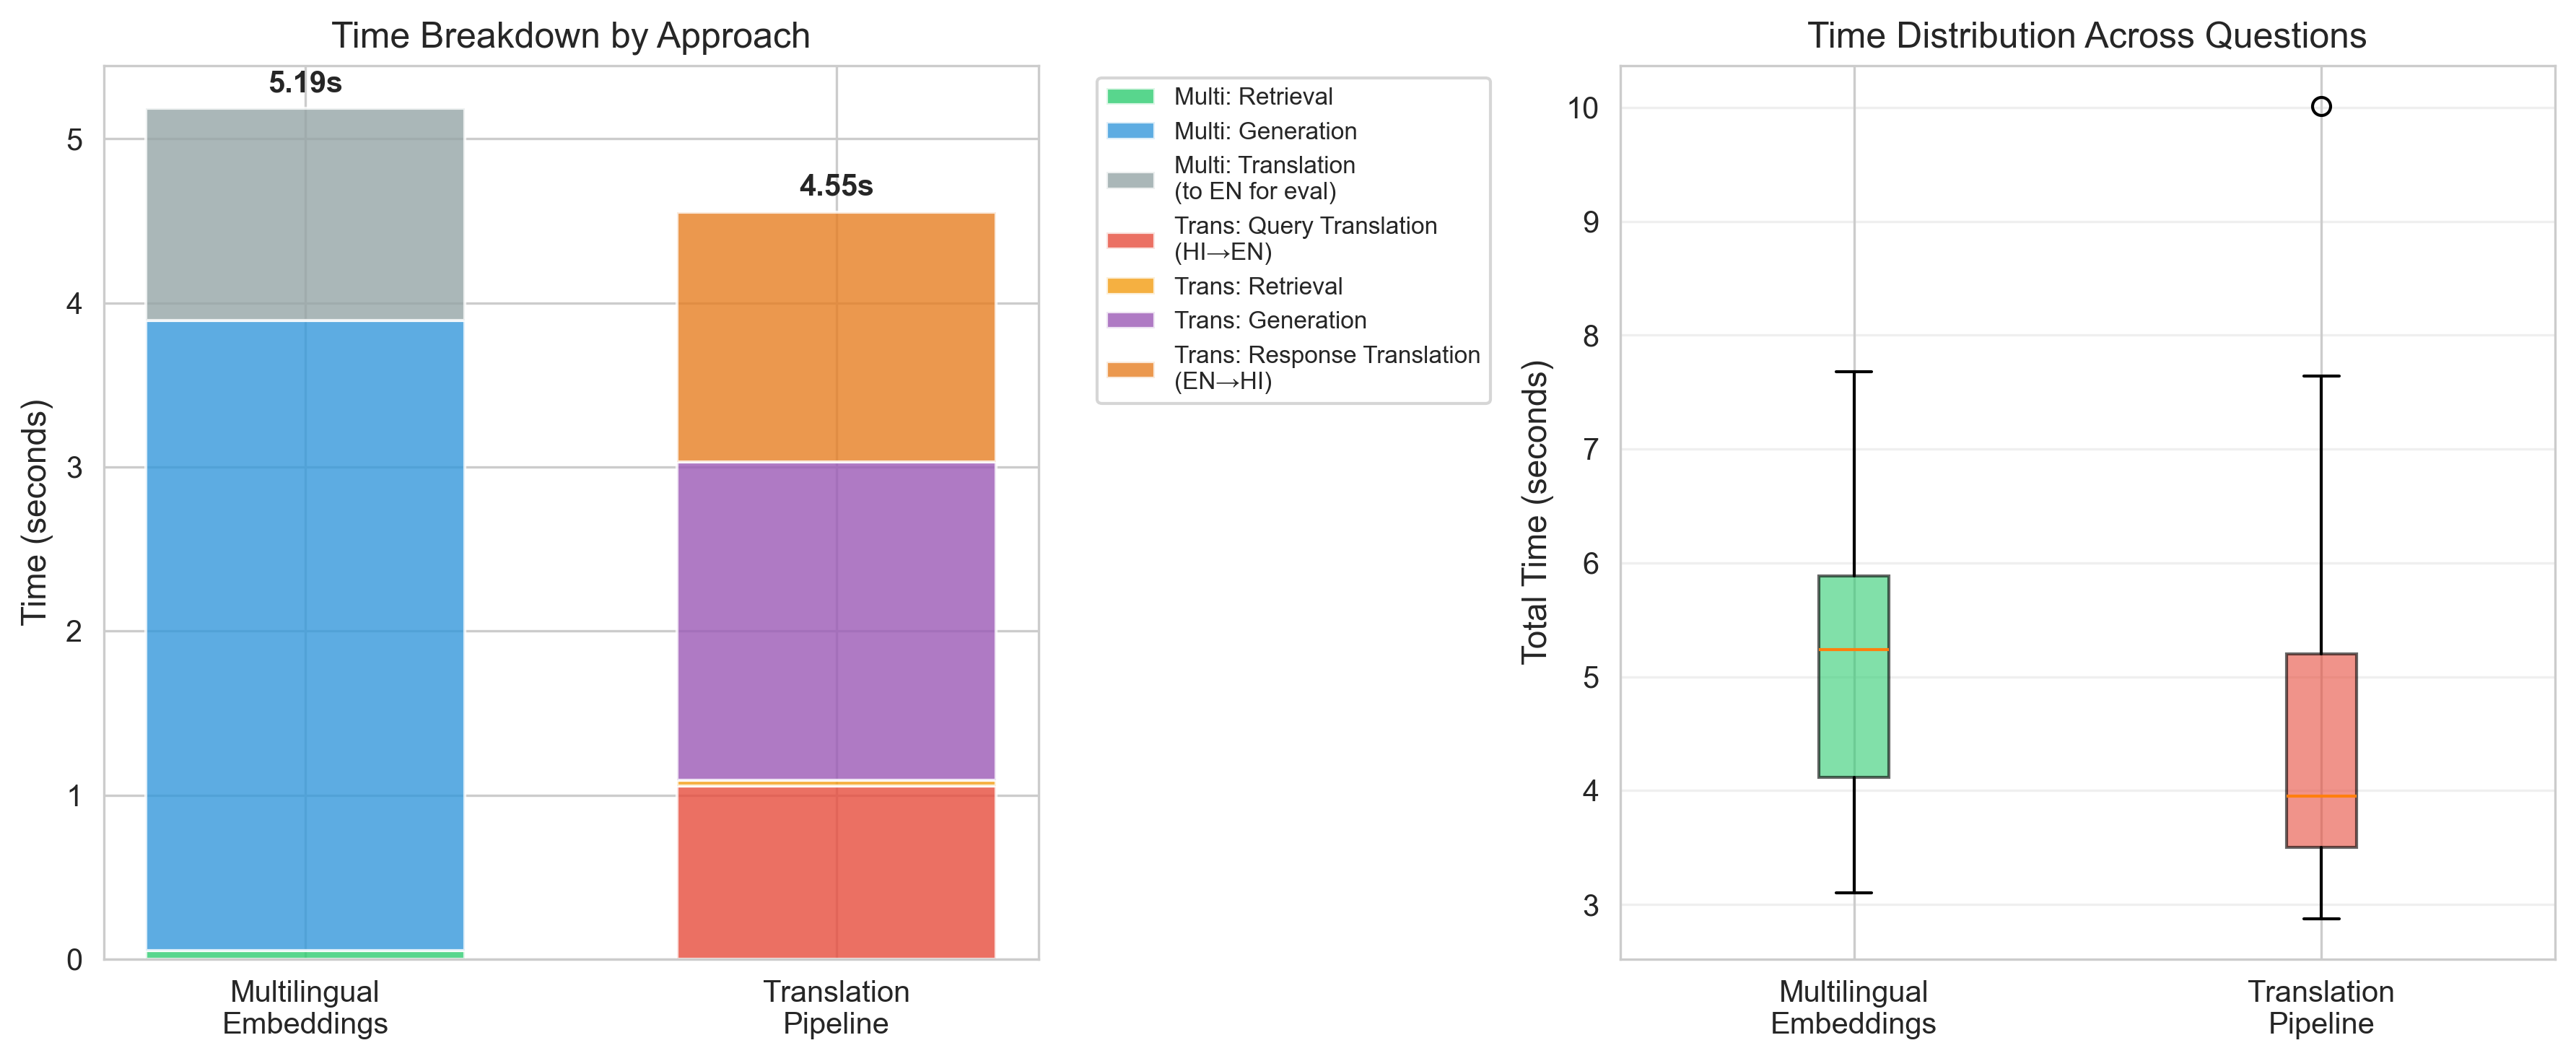


📊 Paired t-test for time difference:
   t-statistic: 2.257, p-value: 0.0317
   ✓ Significant difference (p < 0.05)

2. Quality Metrics Analysis...
✓ Saved quality metrics to C:\Users\Boris\Desktop\code\multilingual-rag\results\figures\quality_metrics.png


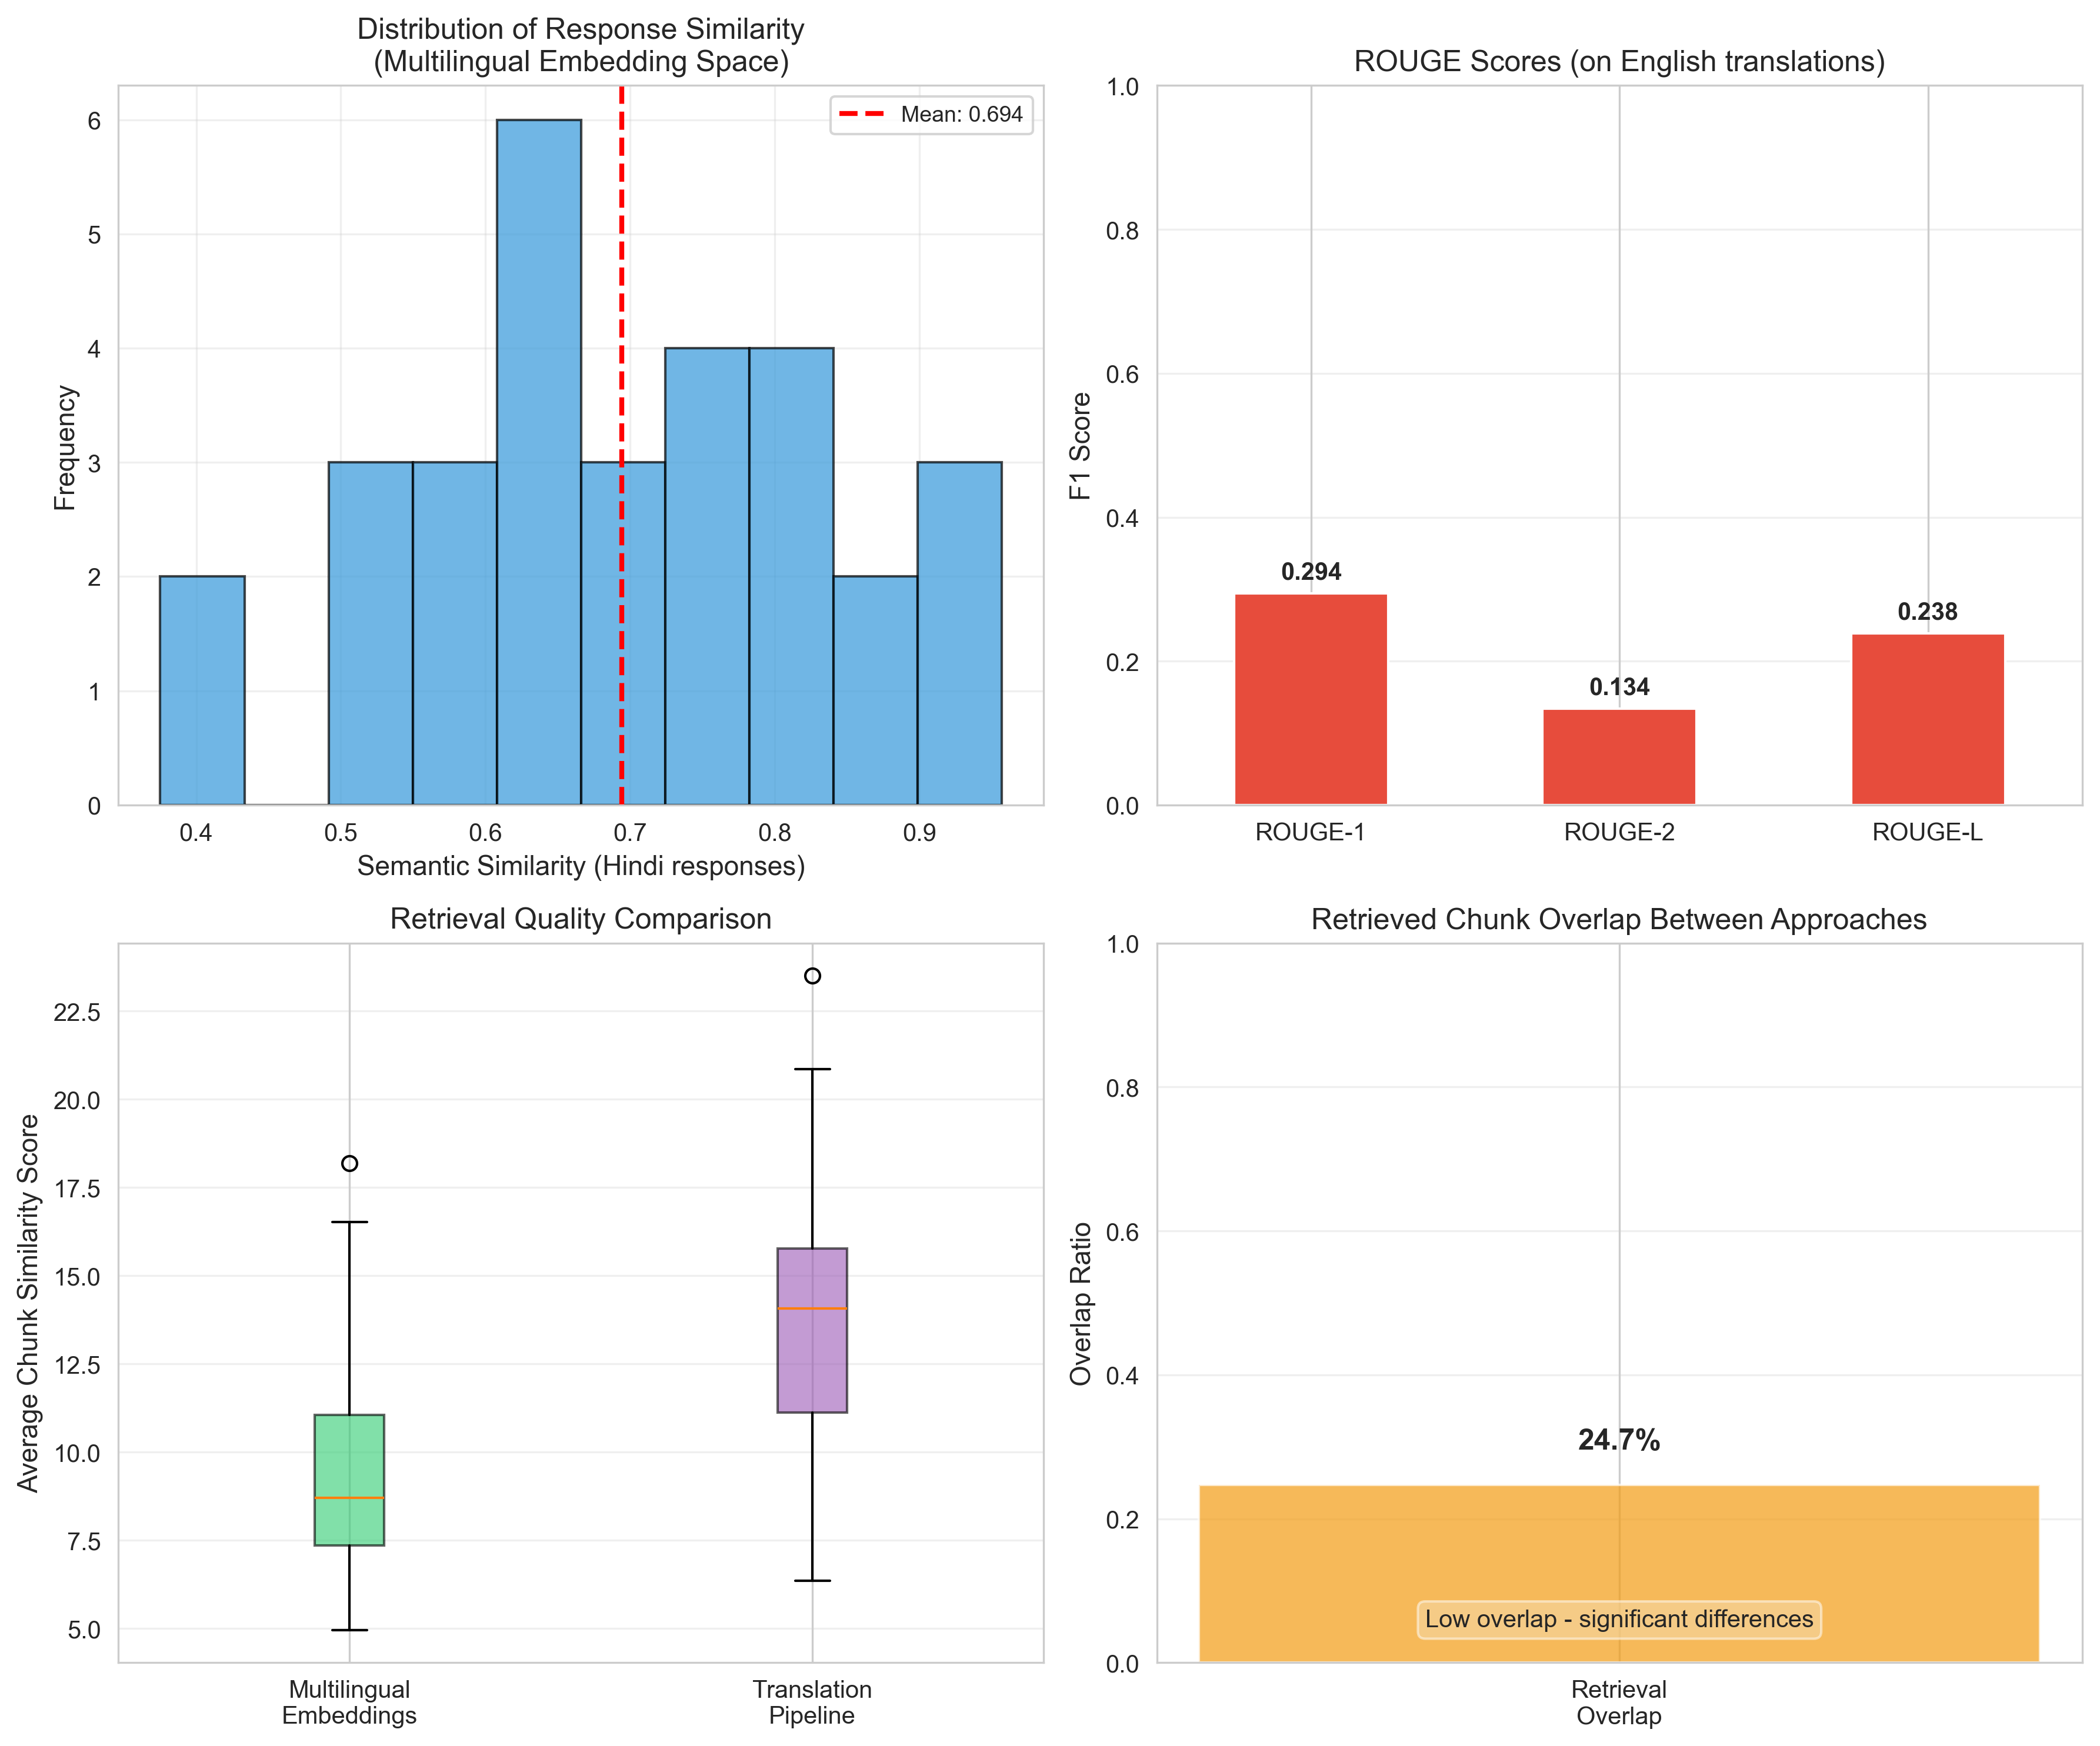


3. Per-Question Analysis...
✓ Saved per-question comparison to C:\Users\Boris\Desktop\code\multilingual-rag\results\figures\per_question.png


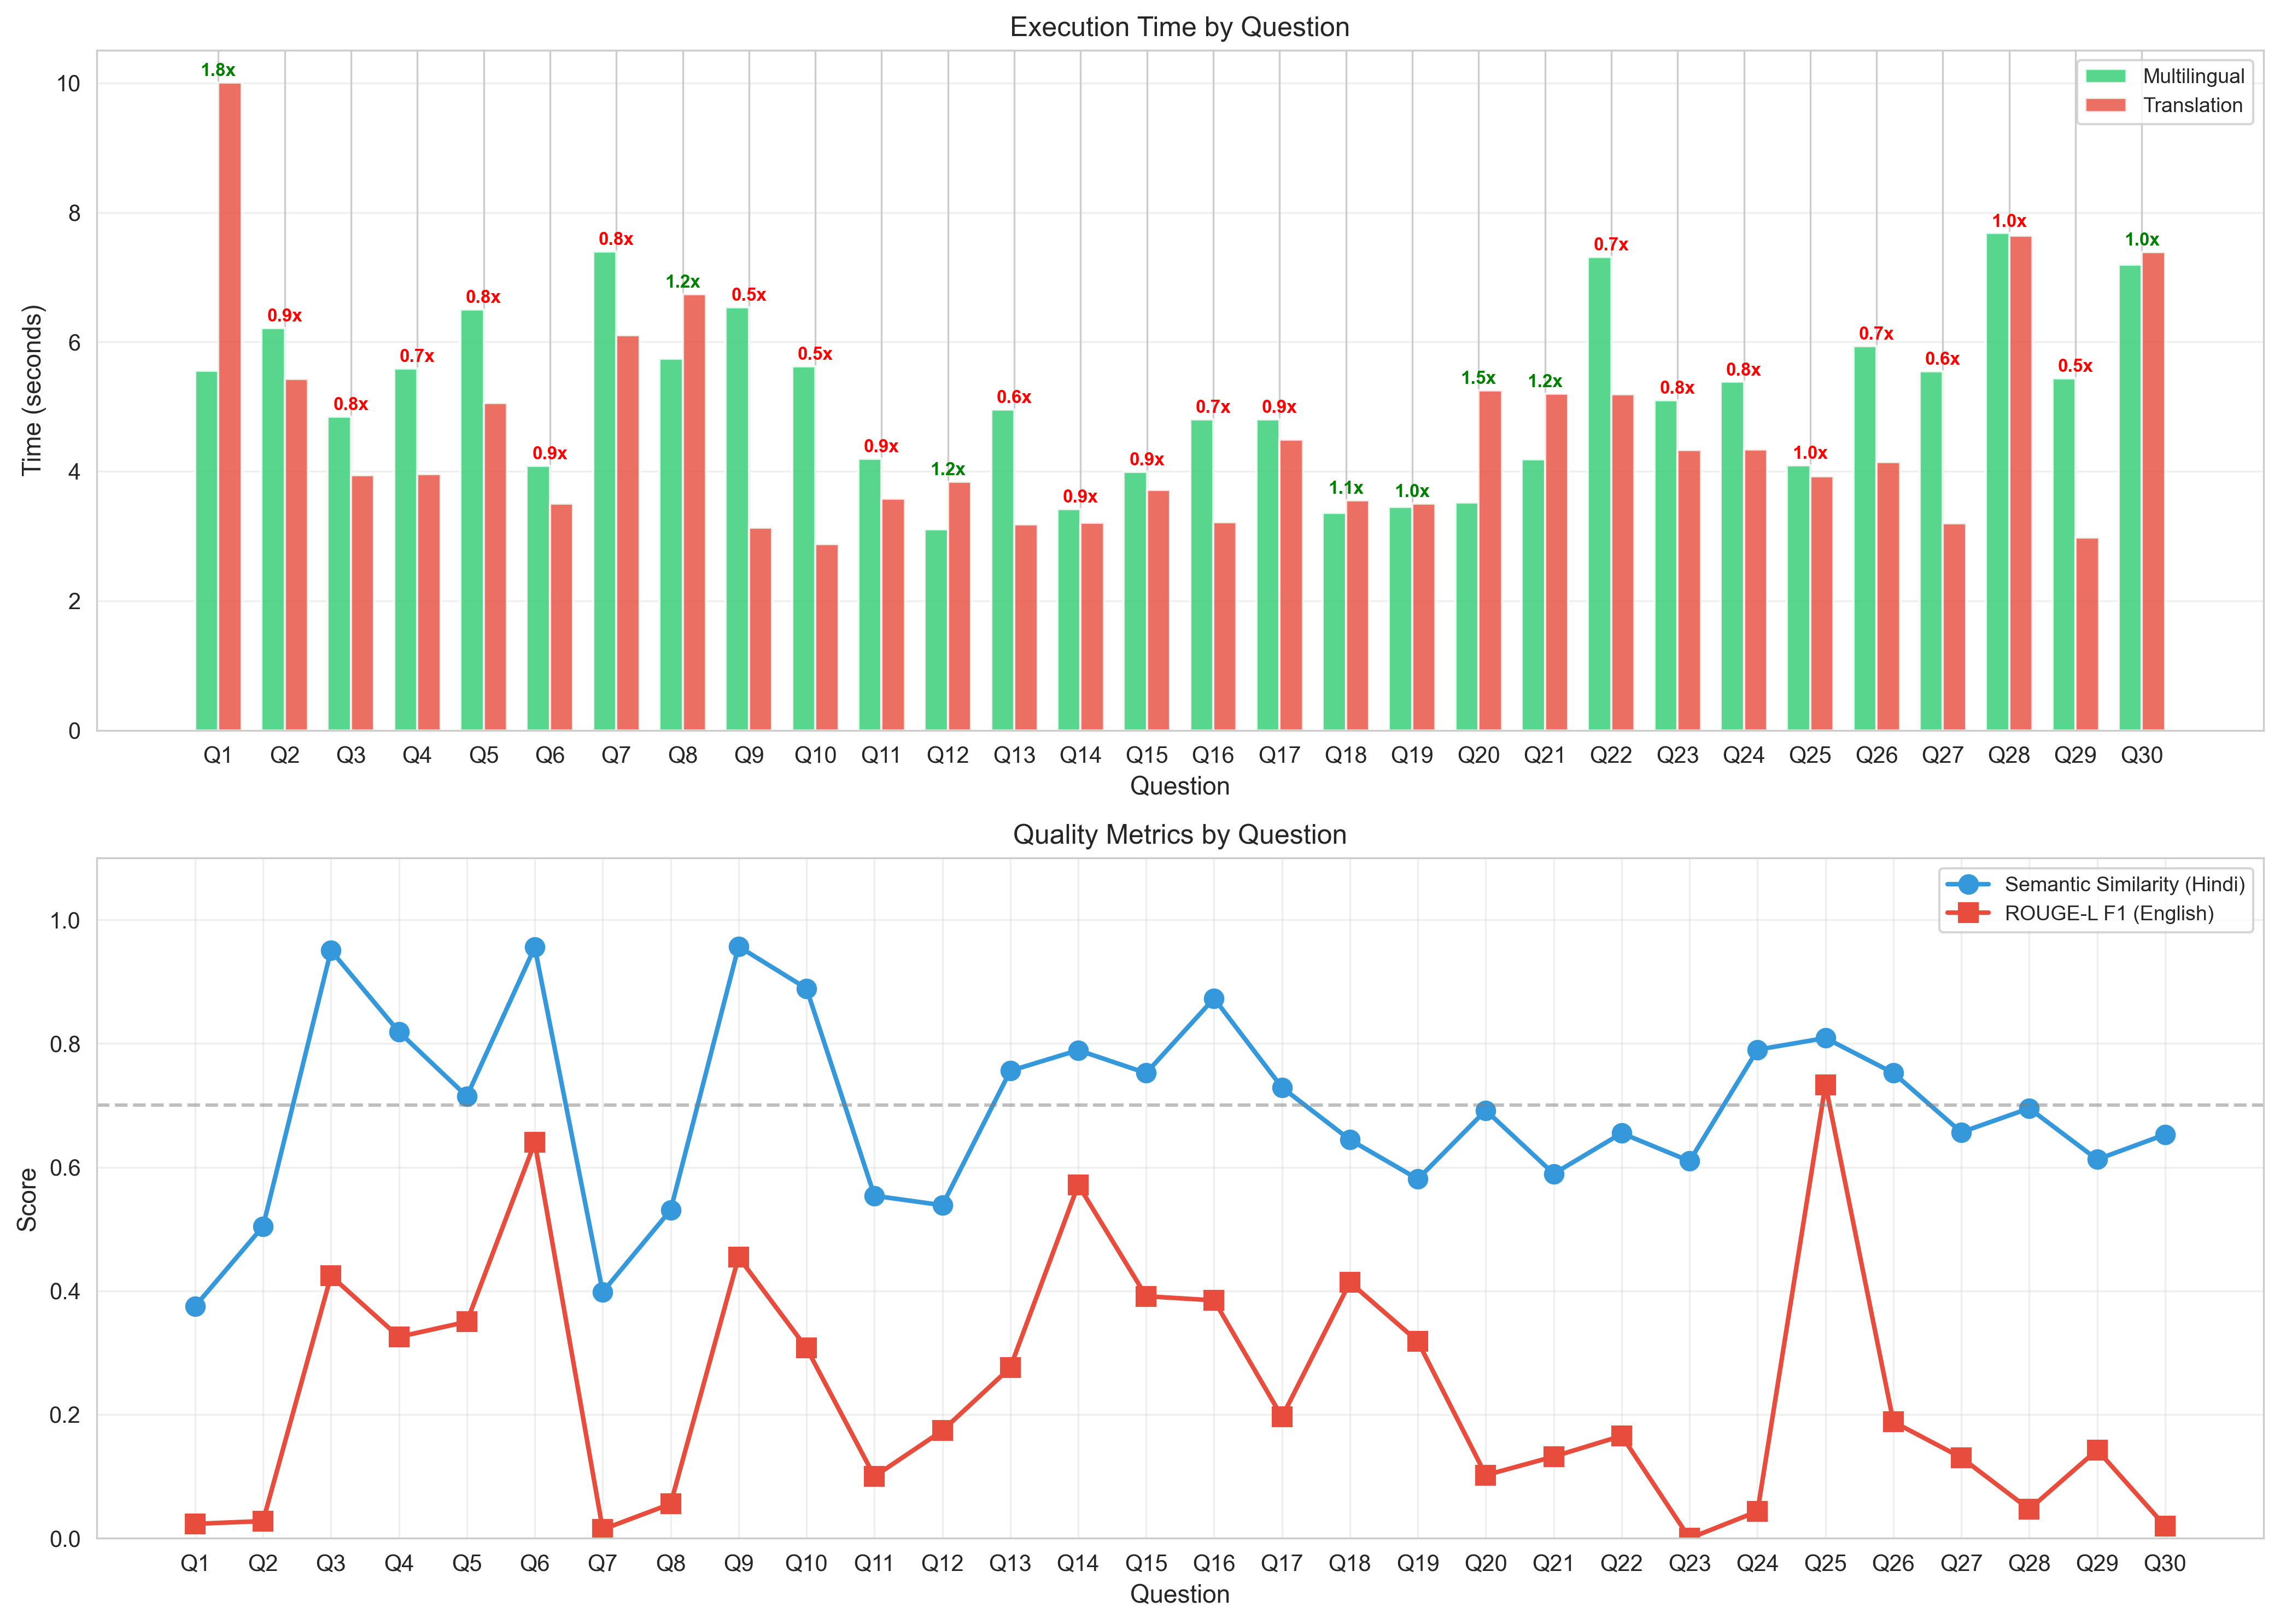


4. Statistical Report...

STATISTICAL REPORT FOR PAPER
                     Metric            Multilingual             Translation P-value        Winner
     Average Total Time (s)           5.186 ± 1.297           4.554 ± 1.643 0.0317*   Translation
Semantic Similarity (Hindi) N/A (comparison metric) N/A (comparison metric)     N/A   Mean: 0.694
                  ROUGE1-F1           Same for both           Same for both     N/A   Mean: 0.294
                  ROUGE2-F1           Same for both           Same for both     N/A   Mean: 0.134
                  ROUGEL-F1           Same for both           Same for both     N/A   Mean: 0.238
        Avg Retrieval Score           9.611 ± 3.141          13.734 ± 4.035 0.0000*   Translation
          Retrieval Overlap                   0.247                   0.247     N/A Same for both


✓ Saved statistical report to C:\Users\Boris\Desktop\code\multilingual-rag\results\figures\statistical_report.csv

✓ All visualizations saved to C:\Users\Bori

In [1]:
# Notebook 4: Hindi Healthcare RAG Evaluation and Visualization

# ============================================================================
# Cell 1 - Setup and Imports
# ============================================================================

import sys
import os
sys.path.append('..')

import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple
import logging

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress matplotlib font warnings for Hindi
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from scipy import stats

import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

ROOT_DIR = Path('..').resolve()
RESULTS_DIR = ROOT_DIR / 'results'

print(f"Results directory: {RESULTS_DIR}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# ============================================================================
# Cell 2 - Load Experiment Results
# ============================================================================

# Load the most recent experiment results
csv_files = list(RESULTS_DIR.glob('hindi_healthcare_rag_*.csv'))

if not csv_files:
    print("❌ No experiment results found. Please run notebook 3 first.")
    raise FileNotFoundError("No experiment results found")
else:
    # Get the most recent file
    latest_file = max(csv_files, key=lambda x: x.stat().st_mtime)
    print(f"Loading: {latest_file.name}")
    
    df_results = pd.read_csv(latest_file, encoding='utf-8')
    print(f"\n✓ Loaded {len(df_results)} experiment results")
    print(f"Columns: {len(df_results.columns)} columns")
    print(f"\nLanguages in dataset: Hindi (all questions)")
    print(f"Questions processed: {len(df_results)}")


# ============================================================================
# Cell 3 - Multilingual RAG Evaluator Class
# ============================================================================

class MultilingualRAGEvaluator:
    """
    Evaluation for cross-lingual RAG systems.
    
    Key innovation: Evaluate in multilingual semantic space to avoid 
    double-translation bias.
    """
    
    def __init__(self, multilingual_model: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        # For semantic similarity in multilingual space
        self.multilingual_encoder = SentenceTransformer(multilingual_model)
        
        # For ROUGE (works on token level)
        self.rouge_scorer_obj = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True
        )
        
        print(f"✓ Initialized evaluator with model: {multilingual_model}")
    
    def calculate_multilingual_semantic_similarity(
        self, 
        text1: str, 
        text2: str
    ) -> float:
        """
        Calculate semantic similarity between two texts in ANY language.
        This avoids translation bias by comparing in shared semantic space.
        """
        embeddings = self.multilingual_encoder.encode([text1, text2])
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        return float(similarity)
    
    def calculate_rouge_on_translated(
        self,
        text1_english: str,
        text2_english: str
    ) -> Dict[str, float]:
        """
        Calculate ROUGE scores on English translations.
        Note: This introduces translation bias but is standard practice.
        """
        scores = self.rouge_scorer_obj.score(text1_english, text2_english)
        return {
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
        }
    
    def evaluate_retrieval_quality(
        self,
        chunk_scores_1: List[float],
        chunk_scores_2: List[float],
        sources_1: List[str],
        sources_2: List[str]
    ) -> Dict[str, float]:
        """Compare retrieval quality between two approaches"""
        result = {}
        
        # Average similarity scores
        if chunk_scores_1:
            result['avg_similarity_score_1'] = np.mean(chunk_scores_1)
            result['min_similarity_score_1'] = np.min(chunk_scores_1)
        else:
            result['avg_similarity_score_1'] = 0.0
            result['min_similarity_score_1'] = 0.0
        
        if chunk_scores_2:
            result['avg_similarity_score_2'] = np.mean(chunk_scores_2)
            result['min_similarity_score_2'] = np.min(chunk_scores_2)
        else:
            result['avg_similarity_score_2'] = 0.0
            result['min_similarity_score_2'] = 0.0
        
        # Source diversity
        result['unique_sources_1'] = len(set(sources_1)) if sources_1 else 0
        result['unique_sources_2'] = len(set(sources_2)) if sources_2 else 0
        
        # Overlap in retrieved chunks (by source)
        if sources_1 and sources_2:
            overlap = len(set(sources_1) & set(sources_2))
            result['retrieval_overlap'] = overlap / max(len(sources_1), len(sources_2))
        else:
            result['retrieval_overlap'] = 0.0
        
        return result
    
    def evaluate_single_question(
        self,
        row: pd.Series
    ) -> Dict[str, float]:
        """Evaluate a single question across both approaches"""
        results = {}
        
        # Get responses in Hindi (what user sees)
        response_multi_hindi = str(row.get('multilingual_response_hindi', ''))
        response_trans_hindi = str(row.get('translation_response_hindi', ''))
        
        # Get responses in English (for evaluation)
        response_multi_en = str(row.get('multilingual_response_english_for_eval', ''))
        response_trans_en = str(row.get('translation_response_english_for_eval', ''))
        
        # ===== Response Quality Evaluation =====
        
        # 1. Multilingual semantic similarity (HINDI responses - no translation bias)
        if response_multi_hindi and response_trans_hindi:
            results['semantic_similarity_hindi'] = self.calculate_multilingual_semantic_similarity(
                response_multi_hindi, response_trans_hindi
            )
        else:
            results['semantic_similarity_hindi'] = 0.0
        
        # 2. ROUGE on English translations (standard practice, but has bias)
        if response_multi_en and response_trans_en:
            rouge_scores = self.calculate_rouge_on_translated(
                response_multi_en, response_trans_en
            )
            results.update(rouge_scores)
        else:
            results.update({
                'rouge1_f1': 0.0, 'rouge2_f1': 0.0, 'rougeL_f1': 0.0,
                'rouge1_precision': 0.0, 'rouge1_recall': 0.0,
                'rouge2_precision': 0.0, 'rouge2_recall': 0.0,
                'rougeL_precision': 0.0, 'rougeL_recall': 0.0,
            })
        
        # ===== Retrieval Quality Evaluation =====
        
        chunk_scores_multi = row.get('multilingual_chunk_scores', [])
        chunk_scores_trans = row.get('translation_chunk_scores', [])
        sources_multi = row.get('multilingual_chunk_sources', [])
        sources_trans = row.get('translation_chunk_sources', [])
        
        # Handle string representations of lists
        if isinstance(chunk_scores_multi, str):
            try:
                chunk_scores_multi = eval(chunk_scores_multi)
            except:
                chunk_scores_multi = []
        
        if isinstance(chunk_scores_trans, str):
            try:
                chunk_scores_trans = eval(chunk_scores_trans)
            except:
                chunk_scores_trans = []
        
        if isinstance(sources_multi, str):
            try:
                sources_multi = eval(sources_multi)
            except:
                sources_multi = []
        
        if isinstance(sources_trans, str):
            try:
                sources_trans = eval(sources_trans)
            except:
                sources_trans = []
        
        retrieval_metrics = self.evaluate_retrieval_quality(
            chunk_scores_multi, chunk_scores_trans,
            sources_multi, sources_trans
        )
        
        # Rename for clarity
        for key, value in retrieval_metrics.items():
            if '_1' in key:
                new_key = key.replace('_1', '_multilingual')
            elif '_2' in key:
                new_key = key.replace('_2', '_translation')
            else:
                new_key = key
            results[new_key] = value
        
        # ===== Time/Efficiency Metrics =====
        
        results['time_multilingual'] = row.get('multilingual_total_time', 0.0)
        results['time_translation'] = row.get('translation_total_time', 0.0)
        results['time_difference'] = results['time_translation'] - results['time_multilingual']
        results['time_speedup'] = (
            results['time_translation'] / results['time_multilingual'] 
            if results['time_multilingual'] > 0 else 0.0
        )
        
        return results
    
    def evaluate_dataset(
        self,
        df_results: pd.DataFrame,
        output_path: str = None
    ) -> pd.DataFrame:
        """Evaluate entire dataset of results"""
        evaluation_results = []
        
        print(f"\nEvaluating {len(df_results)} questions...")
        print("=" * 80)
        
        for idx, row in df_results.iterrows():
            print(f"\n[{idx+1}/{len(df_results)}] {row['question_hindi'][:50]}...")
            
            eval_result = {
                'question_id': row['question_id'],
                'question_hindi': row['question_hindi'],
                'question_english_reference': row.get('question_english_reference', ''),
            }
            
            # Run evaluation
            metrics = self.evaluate_single_question(row)
            eval_result.update(metrics)
            
            # Display key metrics
            print(f"  Semantic similarity (Hindi): {metrics['semantic_similarity_hindi']:.3f}")
            print(f"  ROUGE-L (English): {metrics['rougeL_f1']:.3f}")
            print(f"  Time speedup: {metrics['time_speedup']:.2f}x")
            
            evaluation_results.append(eval_result)
        
        df_eval = pd.DataFrame(evaluation_results)
        
        # Save if path provided
        if output_path:
            Path(output_path).parent.mkdir(parents=True, exist_ok=True)
            df_eval.to_csv(output_path, index=False, encoding='utf-8')
            print(f"\n✓ Saved evaluation to {output_path}")
        
        # Print summary statistics
        self._print_summary(df_eval)
        
        return df_eval
    
    def _print_summary(self, df_eval: pd.DataFrame):
        """Print summary statistics"""
        print("\n" + "=" * 80)
        print("EVALUATION SUMMARY")
        print("=" * 80)
        
        print("\n📊 Response Quality (Semantic Similarity - No Translation Bias):")
        print(f"  Average: {df_eval['semantic_similarity_hindi'].mean():.3f}")
        print(f"  Std Dev: {df_eval['semantic_similarity_hindi'].std():.3f}")
        print(f"  Min:     {df_eval['semantic_similarity_hindi'].min():.3f}")
        print(f"  Max:     {df_eval['semantic_similarity_hindi'].max():.3f}")
        
        print("\n📊 Response Quality (ROUGE-L on English translations):")
        print(f"  Average F1: {df_eval['rougeL_f1'].mean():.3f}")
        print(f"  Precision:  {df_eval['rougeL_precision'].mean():.3f}")
        print(f"  Recall:     {df_eval['rougeL_recall'].mean():.3f}")
        
        print("\n⏱️  Time Efficiency:")
        print(f"  Multilingual approach: {df_eval['time_multilingual'].mean():.2f}s ± {df_eval['time_multilingual'].std():.2f}s")
        print(f"  Translation approach:  {df_eval['time_translation'].mean():.2f}s ± {df_eval['time_translation'].std():.2f}s")
        print(f"  Average speedup:       {df_eval['time_speedup'].mean():.2f}x")
        
        print("\n🔍 Retrieval Quality:")
        print(f"  Multilingual avg score: {df_eval['avg_similarity_score_multilingual'].mean():.3f}")
        print(f"  Translation avg score:  {df_eval['avg_similarity_score_translation'].mean():.3f}")
        print(f"  Retrieval overlap:      {df_eval['retrieval_overlap'].mean():.1%}")
        
        # Determine winner
        print("\n🏆 WINNER:")
        if df_eval['semantic_similarity_hindi'].mean() > 0.9:
            print("  Both approaches produce highly similar results")
            if df_eval['time_multilingual'].mean() < df_eval['time_translation'].mean():
                print("  → Multilingual embeddings RECOMMENDED (faster, similar quality)")
            else:
                print("  → Translation approach RECOMMENDED (similar time, potentially better retrieval)")
        elif df_eval['semantic_similarity_hindi'].mean() > 0.7:
            print("  Approaches differ moderately - further analysis needed")
        else:
            print("  ⚠️  Significant differences detected - investigate individual cases")


# Initialize evaluator
evaluator = MultilingualRAGEvaluator(
    multilingual_model='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
)


# ============================================================================
# Cell 4 - Run Evaluation
# ============================================================================

# Run evaluation
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
eval_output = RESULTS_DIR / f'evaluation_{timestamp}.csv'

df_evaluation = evaluator.evaluate_dataset(
    df_results=df_results,
    output_path=str(eval_output)
)

print(f"\n✓ Evaluation complete!")
print(f"  Results shape: {df_evaluation.shape}")


# ============================================================================
# Cell 5 - Visualization and Analysis Class
# ============================================================================

class RAGVisualizationAnalysis:
    """Generate publication-ready visualizations and statistical tests"""
    
    def __init__(self, df_results: pd.DataFrame, df_evaluation: pd.DataFrame):
        self.df_results = df_results
        self.df_eval = df_evaluation
        
        # Set style for publication
        sns.set_style('whitegrid')
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['font.size'] = 10
        plt.rcParams['axes.labelsize'] = 11
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['legend.fontsize'] = 9
    
    def plot_time_comparison(self, save_path: str = None):
        """Compare execution time: breakdown by component"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Extract time components
        multi_times = pd.DataFrame({
            'Retrieval': self.df_results['multilingual_retrieval_time'],
            'Generation': self.df_results['multilingual_generation_time'],
            'Translation\n(to EN for eval)': self.df_results['multilingual_response_translation_time']
        })
        
        trans_times = pd.DataFrame({
            'Query Translation\n(HI→EN)': self.df_results['translation_question_translation_time'],
            'Retrieval': self.df_results['translation_retrieval_time'],
            'Generation': self.df_results['translation_generation_time'],
            'Response Translation\n(EN→HI)': self.df_results['translation_response_translation_time']
        })
        
        # Plot 1: Stacked bar chart
        ax1 = axes[0]
        multi_means = multi_times.mean()
        trans_means = trans_times.mean()
        
        x = np.arange(2)
        width = 0.6
        
        # Multilingual stack
        bottom_m = 0
        colors_m = ['#2ecc71', '#3498db', '#95a5a6']
        for idx, (component, value) in enumerate(multi_means.items()):
            ax1.bar(0, value, width, bottom=bottom_m, 
                   label=f'Multi: {component}', color=colors_m[idx], alpha=0.8)
            bottom_m += value
        
        # Translation stack
        bottom_t = 0
        colors_t = ['#e74c3c', '#f39c12', '#9b59b6', '#e67e22']
        for idx, (component, value) in enumerate(trans_means.items()):
            ax1.bar(1, value, width, bottom=bottom_t,
                   label=f'Trans: {component}', color=colors_t[idx], alpha=0.8)
            bottom_t += value
        
        ax1.set_xticks(x)
        ax1.set_xticklabels(['Multilingual\nEmbeddings', 'Translation\nPipeline'])
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Time Breakdown by Approach')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Add total time annotations
        ax1.text(0, bottom_m + 0.1, f'{bottom_m:.2f}s', ha='center', fontweight='bold')
        ax1.text(1, bottom_t + 0.1, f'{bottom_t:.2f}s', ha='center', fontweight='bold')
        
        # Plot 2: Box plot for variance
        ax2 = axes[1]
        total_times_data = pd.DataFrame({
            'Multilingual': self.df_results['multilingual_total_time'],
            'Translation': self.df_results['translation_total_time']
        })
        
        bp = ax2.boxplot([total_times_data['Multilingual'], total_times_data['Translation']],
                         labels=['Multilingual\nEmbeddings', 'Translation\nPipeline'],
                         patch_artist=True)
        
        for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax2.set_ylabel('Total Time (seconds)')
        ax2.set_title('Time Distribution Across Questions')
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved time comparison to {save_path}")
        
        plt.show()
        
        # Statistical test
        t_stat, p_value = stats.ttest_rel(
            self.df_results['multilingual_total_time'],
            self.df_results['translation_total_time']
        )
        print(f"\n📊 Paired t-test for time difference:")
        print(f"   t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"   ✓ Significant difference (p < 0.05)")
        else:
            print(f"   ✗ No significant difference (p >= 0.05)")
    
    def plot_quality_metrics(self, save_path: str = None):
        """Compare quality metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: Semantic similarity distribution
        ax1 = axes[0, 0]
        ax1.hist(self.df_eval['semantic_similarity_hindi'], bins=10, 
                edgecolor='black', color='#3498db', alpha=0.7)
        ax1.axvline(self.df_eval['semantic_similarity_hindi'].mean(), 
                   color='red', linestyle='--', linewidth=2, 
                   label=f"Mean: {self.df_eval['semantic_similarity_hindi'].mean():.3f}")
        ax1.set_xlabel('Semantic Similarity (Hindi responses)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Response Similarity\n(Multilingual Embedding Space)')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Plot 2: ROUGE scores comparison
        ax2 = axes[0, 1]
        rouge_scores = pd.DataFrame({
            'ROUGE-1': [self.df_eval['rouge1_f1'].mean()],
            'ROUGE-2': [self.df_eval['rouge2_f1'].mean()],
            'ROUGE-L': [self.df_eval['rougeL_f1'].mean()]
        })
        
        rouge_scores.T.plot(kind='bar', ax=ax2, legend=False, color='#e74c3c')
        ax2.set_ylabel('F1 Score')
        ax2.set_title('ROUGE Scores (on English translations)')
        ax2.set_xticklabels(rouge_scores.columns, rotation=0)
        ax2.set_ylim([0, 1])
        ax2.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(rouge_scores.values[0]):
            ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
        
        # Plot 3: Retrieval quality comparison
        ax3 = axes[1, 0]
        retrieval_data = pd.DataFrame({
            'Multilingual': self.df_eval['avg_similarity_score_multilingual'],
            'Translation': self.df_eval['avg_similarity_score_translation']
        })
        
        bp = ax3.boxplot([retrieval_data['Multilingual'], retrieval_data['Translation']],
                        labels=['Multilingual\nEmbeddings', 'Translation\nPipeline'],
                        patch_artist=True)
        
        for patch, color in zip(bp['boxes'], ['#2ecc71', '#9b59b6']):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax3.set_ylabel('Average Chunk Similarity Score')
        ax3.set_title('Retrieval Quality Comparison')
        ax3.grid(axis='y', alpha=0.3)
        
        # Plot 4: Retrieval overlap
        ax4 = axes[1, 1]
        overlap_mean = self.df_eval['retrieval_overlap'].mean()
        
        ax4.bar(['Retrieval\nOverlap'], [overlap_mean], color='#f39c12', alpha=0.7)
        ax4.set_ylim([0, 1])
        ax4.set_ylabel('Overlap Ratio')
        ax4.set_title('Retrieved Chunk Overlap Between Approaches')
        ax4.text(0, overlap_mean + 0.05, f'{overlap_mean:.1%}', 
                ha='center', fontweight='bold', fontsize=12)
        ax4.grid(axis='y', alpha=0.3)
        
        # Add interpretation text
        if overlap_mean > 0.7:
            interpretation = "High overlap - similar retrieval"
        elif overlap_mean > 0.4:
            interpretation = "Moderate overlap - some differences"
        else:
            interpretation = "Low overlap - significant differences"
        
        ax4.text(0, 0.05, interpretation, ha='center', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved quality metrics to {save_path}")
        
        plt.show()
    
    def plot_per_question_comparison(self, save_path: str = None):
        """Question-by-question comparison"""
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Use simple question numbers instead of Hindi text
        questions = [f"Q{i+1}" for i in range(len(self.df_eval))]
        x = np.arange(len(questions))
        width = 0.35
        
        # Plot 1: Time comparison per question
        ax1 = axes[0]
        bars1 = ax1.bar(x - width/2, self.df_eval['time_multilingual'], 
                       width, label='Multilingual', color='#2ecc71', alpha=0.8)
        bars2 = ax1.bar(x + width/2, self.df_eval['time_translation'], 
                       width, label='Translation', color='#e74c3c', alpha=0.8)
        
        ax1.set_xlabel('Question')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Execution Time by Question')
        ax1.set_xticks(x)
        ax1.set_xticklabels(questions, rotation=0)  # No rotation needed now
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Add speedup annotations
        for i, (t_multi, t_trans) in enumerate(zip(self.df_eval['time_multilingual'], 
                                                     self.df_eval['time_translation'])):
            if t_multi > 0:
                speedup = t_trans / t_multi
                color = 'green' if speedup > 1 else 'red'
                ax1.text(i, max(t_multi, t_trans) + 0.1, f'{speedup:.1f}x',
                        ha='center', fontsize=8, color=color, fontweight='bold')
        
        # Plot 2: Quality metrics per question
        ax2 = axes[1]
        
        semantic_sim = self.df_eval['semantic_similarity_hindi']
        
        ax2.plot(x, semantic_sim, 'o-', label='Semantic Similarity (Hindi)', 
                linewidth=2, markersize=8, color='#3498db')
        ax2.plot(x, self.df_eval['rougeL_f1'], 's-', label='ROUGE-L F1 (English)', 
                linewidth=2, markersize=8, color='#e74c3c')
        
        ax2.set_xlabel('Question')
        ax2.set_ylabel('Score')
        ax2.set_title('Quality Metrics by Question')
        ax2.set_xticks(x)
        ax2.set_xticklabels(questions, rotation=0)
        ax2.set_ylim([0, 1.1])
        ax2.legend()
        ax2.grid(alpha=0.3)
        ax2.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved per-question comparison to {save_path}")
        
        plt.show()
    
    def generate_statistical_report(self) -> pd.DataFrame:
        """Generate comprehensive statistical report for paper"""
        
        report = []
        
        # Time metrics
        t_stat_time, p_val_time = stats.ttest_rel(
            self.df_eval['time_multilingual'],
            self.df_eval['time_translation']
        )
        
        report.append({
            'Metric': 'Average Total Time (s)',
            'Multilingual': f"{self.df_eval['time_multilingual'].mean():.3f} ± {self.df_eval['time_multilingual'].std():.3f}",
            'Translation': f"{self.df_eval['time_translation'].mean():.3f} ± {self.df_eval['time_translation'].std():.3f}",
            'P-value': f"{p_val_time:.4f}{'*' if p_val_time < 0.05 else ''}",
            'Winner': 'Multilingual' if self.df_eval['time_multilingual'].mean() < self.df_eval['time_translation'].mean() else 'Translation'
        })
        
        # Semantic similarity
        report.append({
            'Metric': 'Semantic Similarity (Hindi)',
            'Multilingual': 'N/A (comparison metric)',
            'Translation': 'N/A (comparison metric)',
            'P-value': 'N/A',
            'Winner': f"Mean: {self.df_eval['semantic_similarity_hindi'].mean():.3f}"
        })
        
        # ROUGE scores
        for rouge_type in ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']:
            report.append({
                'Metric': f'{rouge_type.upper().replace("_", "-")}',
                'Multilingual': 'Same for both',
                'Translation': 'Same for both',
                'P-value': 'N/A',
                'Winner': f"Mean: {self.df_eval[rouge_type].mean():.3f}"
            })
        
        # Retrieval quality
        t_stat_ret, p_val_ret = stats.ttest_rel(
            self.df_eval['avg_similarity_score_multilingual'],
            self.df_eval['avg_similarity_score_translation']
        )
        
        report.append({
            'Metric': 'Avg Retrieval Score',
            'Multilingual': f"{self.df_eval['avg_similarity_score_multilingual'].mean():.3f} ± {self.df_eval['avg_similarity_score_multilingual'].std():.3f}",
            'Translation': f"{self.df_eval['avg_similarity_score_translation'].mean():.3f} ± {self.df_eval['avg_similarity_score_translation'].std():.3f}",
            'P-value': f"{p_val_ret:.4f}{'*' if p_val_ret < 0.05 else ''}",
            'Winner': 'Multilingual' if self.df_eval['avg_similarity_score_multilingual'].mean() > self.df_eval['avg_similarity_score_translation'].mean() else 'Translation'
        })
        
        # Retrieval overlap
        report.append({
            'Metric': 'Retrieval Overlap',
            'Multilingual': f"{self.df_eval['retrieval_overlap'].mean():.3f}",
            'Translation': f"{self.df_eval['retrieval_overlap'].mean():.3f}",
            'P-value': 'N/A',
            'Winner': 'Same for both'
        })
        
        df_report = pd.DataFrame(report)
        
        print("\n" + "=" * 100)
        print("STATISTICAL REPORT FOR PAPER")
        print("=" * 100)
        print(df_report.to_string(index=False))
        print("\n" + "=" * 100)
        
        return df_report
    
    def generate_all_visualizations(self, output_dir: str = None):
        """Generate all visualizations at once"""
        if output_dir:
            output_path = Path(output_dir)
            output_path.mkdir(parents=True, exist_ok=True)
        else:
            output_path = RESULTS_DIR / 'figures'
            output_path.mkdir(parents=True, exist_ok=True)
        
        print("\n" + "=" * 80)
        print("GENERATING ALL VISUALIZATIONS")
        print("=" * 80)
        
        # Generate each plot
        print("\n1. Time Comparison Analysis...")
        self.plot_time_comparison(save_path=str(output_path / 'time_comparison.png'))
        
        print("\n2. Quality Metrics Analysis...")
        self.plot_quality_metrics(save_path=str(output_path / 'quality_metrics.png'))
        
        print("\n3. Per-Question Analysis...")
        self.plot_per_question_comparison(save_path=str(output_path / 'per_question.png'))
        
        # Generate statistical report
        print("\n4. Statistical Report...")
        df_report = self.generate_statistical_report()
        report_path = output_path / 'statistical_report.csv'
        df_report.to_csv(report_path, index=False)
        print(f"\n✓ Saved statistical report to {report_path}")
        
        print("\n" + "=" * 80)
        print(f"✓ All visualizations saved to {output_path}")
        print("=" * 80)
        
        return df_report


# ============================================================================
# Cell 6 - Generate All Visualizations and Print Responses
# ============================================================================

# Create visualization analyzer
viz_analyzer = RAGVisualizationAnalysis(
    df_results=df_results,
    df_evaluation=df_evaluation
)

# Generate all plots and statistical analysis
print("\n" + "=" * 80)
print("GENERATING PUBLICATION-READY VISUALIZATIONS")
print("=" * 80)

figures_dir = RESULTS_DIR / 'figures'
df_statistical_report = viz_analyzer.generate_all_visualizations(output_dir=str(figures_dir))

# ============================================================================
# PRINT HINDI RESPONSES FOR SPOT CHECKING
# ============================================================================

print("\n" + "=" * 100)
print("HINDI RESPONSES - SPOT CHECK")
print("=" * 100)

for idx, row in df_results.iterrows():
    print(f"\n{'='*100}")
    print(f"Question {idx+1}: {row['question_hindi']}")
    print(f"English Ref: {row['question_english_reference']}")
    print(f"{'='*100}")
    
    # Multilingual Embedding Approach
    print(f"\n📍 APPROACH A: Multilingual Embeddings")
    print(f"   Time: {row['multilingual_total_time']:.2f}s")
    print(f"\n   Response (Hindi):")
    print(f"   {row['multilingual_response_hindi']}")
    print(f"\n   Response (English - for eval):")
    print(f"   {row['multilingual_response_english_for_eval'][:300]}...")
    
    # Translation Pipeline Approach
    print(f"\n📍 APPROACH B: Translation Pipeline")
    print(f"   Time: {row['translation_total_time']:.2f}s")
    print(f"   Query translated to: {row['translation_question_english']}")
    print(f"\n   Response (Hindi):")
    print(f"   {row['translation_response_hindi']}")
    print(f"\n   Response (English - for eval):")
    print(f"   {row['translation_response_english_for_eval'][:300]}...")
    
    # Show similarity
    eval_row = df_evaluation[df_evaluation['question_id'] == row['question_id']].iloc[0]
    print(f"\n📊 Similarity Metrics:")
    print(f"   Semantic Similarity (Hindi): {eval_row['semantic_similarity_hindi']:.3f}")
    print(f"   ROUGE-L (English): {eval_row['rougeL_f1']:.3f}")
    print(f"   Time difference: {eval_row['time_difference']:.2f}s")
    
    print("\n" + "-"*100)

# Display final summary
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\nGenerated files:")
print(f"  1. {eval_output}")
print(f"  2. {figures_dir / 'time_comparison.png'}")
print(f"  3. {figures_dir / 'quality_metrics.png'}")
print(f"  4. {figures_dir / 'per_question.png'}")
print(f"  5. {figures_dir / 'statistical_report.csv'}")

print("\n" + "=" * 80)
print("=" * 80)
print("\nKey Findings Summary:")
print(f"  • Semantic Similarity: {df_evaluation['semantic_similarity_hindi'].mean():.3f}")
print(f"  • Avg Time (Multilingual): {df_evaluation['time_multilingual'].mean():.2f}s")
print(f"  • Avg Time (Translation): {df_evaluation['time_translation'].mean():.2f}s")
print(f"  • Retrieval Overlap: {df_evaluation['retrieval_overlap'].mean():.1%}")

# Determine recommendation
if df_evaluation['semantic_similarity_hindi'].mean() > 0.8:
    if df_evaluation['time_multilingual'].mean() < df_evaluation['time_translation'].mean():
        recommendation = "Multilingual Embeddings (Similar quality, faster)"
    else:
        recommendation = "Translation Pipeline (Similar quality, comparable time)"
else:
    recommendation = "Further investigation needed - significant differences"

print(f"\n🏆 RECOMMENDATION: {recommendation}")
print("=" * 80)

# Save responses to text file for easier review
responses_file = RESULTS_DIR / f'responses_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(responses_file, 'w', encoding='utf-8') as f:
    f.write("HINDI HEALTHCARE RAG - RESPONSE COMPARISON\n")
    f.write("="*100 + "\n\n")
    
    for idx, row in df_results.iterrows():
        f.write(f"\nQuestion {idx+1}: {row['question_hindi']}\n")
        f.write(f"English: {row['question_english_reference']}\n")
        f.write("="*100 + "\n\n")
        
        f.write("MULTILINGUAL EMBEDDINGS APPROACH:\n")
        f.write(f"{row['multilingual_response_hindi']}\n\n")
        
        f.write("TRANSLATION PIPELINE APPROACH:\n")
        f.write(f"{row['translation_response_hindi']}\n\n")
        
        f.write("-"*100 + "\n\n")

print(f"\n✓ Responses saved to: {responses_file}")